## Machine Learning Project - Introduction / Overview


### General Conditions
*   Course of Studies: Advanced Business Analytics
*   Lecturer: Prof. Dr. Jianmin Chen
*   Students: Moritz Moser, Laurin Leiwes, Dennis Hug
*   Semester Term: Summer Semester 2022

#### Task of Examination
*   Train an advanced Machine Learning Model and Final Presentation

#### About our Machine Learning Project
*   The project deals with the automated recognition of human emotions (facial expressions)
*   To ensure this we are to train a neural network in the following notebook, which deals exactly with the above specified task
*   In general, the user should be enabled to classify his own emotion (facial expression) by uploading a picture of himself or by looking into a camera that is connected to the web-application
*   Furthermore, the project contains a web-application that is built for a better and simplified user experience concerning the neural networks operation process
*   This notebook was made to be executed using Google Colab




## Data Wrangling - Extracting Data Set and Pre-Processing

### First Steps
* First of all we need to extract the data (spartial data / images) that we get form the kaggle website. That being said, we need to download it via kaggle by creating a kaggle account and request the Kaggle API key. Afterwards we need to ensure that we put the kaggle.json file into root/kaggle/ directory
* We continue by extracting the pixel values in the seperate folders of their corresponding emotions + store them in their dedicated directories


#### At the very beginning it is mandatory to import all required libraries



*   Pandas for accessing the data and transforming it into an object of the class dataframe
*   Numpy for math operations (processing multi-dimensional arrays / vectors)
*   OS module for interacting with the operating system (chdir, mkdir, getcwd)
*   cv2 for computer vision tasks (processing images)
*   tqdm to visualize the speed of processing



In [1]:
import pandas as pd
import numpy as np 
import os
import cv2
from tqdm import tqdm

In [2]:
#check versions of imports
lib_names = [pd, np, os,cv2,tqdm]
for lib in lib_names:
  try:
    print(lib.__name__ +": " +  lib.__version__)
  except AttributeError:
    print(f"Module {lib} has no attribute '__version__'")


pandas: 1.3.5
numpy: 1.21.6
Module <module 'os' from '/usr/lib/python3.7/os.py'> has no attribute '__version__'
cv2.cv2: 4.1.2
Module <class 'tqdm.std.tqdm'> has no attribute '__version__'


#### Download Data Set
#### Basically there are two options to do this
* 1.Using !kaggle datasets download command (a huge detriment is the dependency on the kaggle link and the need to upload the kaggle authorization file)
* 2.Once the data set is downloaded there is the option to store it in your google drive account and access it via mounting google drive

In [ ]:
# mandatory for downloading (this command is ment to fail and only exists to create the kaggle directory for authorization described above)
!kaggle datasets download -d deadskull7/fer2013

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# downloading and then unzipping to .csv
!kaggle datasets download -d deadskull7/fer2013
!unzip fer2013.zip 

 84% 81.0M/96.6M [00:00<00:00, 90.8MB/s]
100% 96.6M/96.6M [00:01<00:00, 99.1MB/s]
Archive:  fer2013.zip
  inflating: fer2013.csv             


In [ ]:
os.getcwdb()

b'/content'

#### Accessing the CSV File as an Object of the Class DataFrame:

*   Below we read the csv file using pandas and convert it into an object called data from class DataFrame
*   The CSV File has 3 columns (emotion, pixels and usage)
*   Emotion is a number that represents a certain human emotion (more on that later)
*   The column "pixels" contains the pixel images in an array format
*   Usage labels indicate if the data is used for training or testing purposes

In [ ]:
data = pd.read_csv("fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


#### Using drive module from google.colab library in order to mount gdrive and get access to stored csv file

In [3]:
# 2nd option: mounting google drive
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
data = pd.read_csv("/gdrive/My Drive/Datasets/fer2013.csv")
data.head(5)

Mounted at /gdrive


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
#get current dir
os.getcwd()

'/content'

In [5]:
#check the file directory
os.chdir('/content/')
os.listdir()

['.config', 'sample_data']

### Lets do some Exploration 
*   The Labels are in the range 0-6 where:
    0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 
    4 = Sad, 5 = Surprise, 6 = Neutral.
*   The column Usage has 3 unique values (PublicTest, PrivateTest, Training). That said, the data is divided into three different "partitions"

In [6]:
from typing import List
labels: List[int] = [label for label in data.emotion]
usage: List[str] = [usage for usage in data.Usage]

print(set(labels),set(usage))

{0, 1, 2, 3, 4, 5, 6} {'Training', 'PublicTest', 'PrivateTest'}


#### Image Extraction


1.   We extract the images from the images column (data["pixels])
2.   Looping through the data set and converting string to float and then storing the float values in a numpy array
3.   Reshaping the image to 48x48
4.   Creating a validiation and train folder (USAGE column)
5.   For each Folder we create 7 folders referring to each label (emotions) 
6.   The images are written (now as proper images using cv2) into the folders according to their label  




In [7]:
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for i, j, k in tqdm(zip(data["emotion"], data["pixels"], data["Usage"])):
    pixel = []
    pixels = j.split(' ')
    for m in pixels:
        value = float(m)
        pixel.append(value)
    pixel = np.array(pixel)
    image = pixel.reshape(48, 48)
    
    if k == "Training":
        if not os.path.exists("train"):
            os.mkdir("train")
        if i == 0:
            if not os.path.exists("train/Angry"):
                os.mkdir("train/Angry")
                path = "train/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1
            else:
                path = "train/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1

        elif i == 1:
            if not os.path.exists("train/Disgust"):
                os.mkdir("train/Disgust")
                path = "train/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1
            else:
                path = "train/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1

        elif i == 2:
            if not os.path.exists("train/Fear"):
                os.mkdir("train/Fear")
                path = "train/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1
            else:
                path = "train/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1

        elif i == 3:
            if not os.path.exists("train/Happy"):
                os.mkdir("train/Happy")
                path = "train/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1
            else:
                path = "train/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1

        elif i == 4:
            if not os.path.exists("train/Sad"):
                os.mkdir("train/Sad")
                path = "train/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1
            else:
                path = "train/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1

        elif i == 5:
            if not os.path.exists("train/Surprise"):
                os.mkdir("train/Surprise")
                path = "train/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1
            else:
                path = "train/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1

        elif i == 6:
            if not os.path.exists("train/Neutral"):
                os.mkdir("train/Neutral")
                path = "train/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
            else:
                path = "train/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
                
    else:
        if not os.path.exists("validation"):
            os.mkdir("validation")
        if i == 0:
            if not os.path.exists("validation/Angry"):
                os.mkdir("validation/Angry")
                path = "validation/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1
            else:
                path = "validation/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1

        elif i == 1:
            if not os.path.exists("validation/Disgust"):
                os.mkdir("validation/Disgust")
                path = "validation/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1
            else:
                path = "validation/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1

        elif i == 2:
            if not os.path.exists("validation/Fear"):
                os.mkdir("validation/Fear")
                path = "validation/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1
            else:
                path = "validation/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1

        elif i == 3:
            if not os.path.exists("validation/Happy"):
                os.mkdir("validation/Happy")
                path = "validation/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1
            else:
                path = "validation/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1

        elif i == 4:
            if not os.path.exists("validation/Sad"):
                os.mkdir("validation/Sad")
                path = "validation/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1
            else:
                path = "validation/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1

        elif i == 5:
            if not os.path.exists("validation/Surprise"):
                os.mkdir("validation/Surprise")
                path = "validation/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1
            else:
                path = "validation/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1

        elif i == 6:
            if not os.path.exists("validation/Neutral"):
                os.mkdir("validation/Neutral")
                path = "validation/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
            else:
                path = "validation/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1

35887it [00:36, 987.01it/s] 


#####  Optional: Writing the dataset in its final stage to google drive

In [ ]:
os.chdir("/gdrive/My Drive/Datasets/")
os.getcwd()

'/gdrive/My Drive/Datasets'

In [ ]:
"""
Same Process as above is executed for storing data into google drive cloud 
"""
count0 = 0
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
count6 = 0

for i, j, k in tqdm(zip(data["emotion"], data["pixels"], data["Usage"])):
    pixel = []
    pixels = j.split(' ')
    for m in pixels:
        value = float(m)
        pixel.append(value)
    pixel = np.array(pixel)
    image = pixel.reshape(48, 48)
    
    if k == "Training":
        if not os.path.exists("train"):
            os.mkdir("train")
        if i == 0:
            if not os.path.exists("train/Angry"):
                os.mkdir("train/Angry")
                path = "train/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1
            else:
                path = "train/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1

        elif i == 1:
            if not os.path.exists("train/Disgust"):
                os.mkdir("train/Disgust")
                path = "train/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1
            else:
                path = "train/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1

        elif i == 2:
            if not os.path.exists("train/Fear"):
                os.mkdir("train/Fear")
                path = "train/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1
            else:
                path = "train/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1

        elif i == 3:
            if not os.path.exists("train/Happy"):
                os.mkdir("train/Happy")
                path = "train/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1
            else:
                path = "train/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1

        elif i == 4:
            if not os.path.exists("train/Sad"):
                os.mkdir("train/Sad")
                path = "train/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1
            else:
                path = "train/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1

        elif i == 5:
            if not os.path.exists("train/Surprise"):
                os.mkdir("train/Surprise")
                path = "train/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1
            else:
                path = "train/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1

        elif i == 6:
            if not os.path.exists("train/Neutral"):
                os.mkdir("train/Neutral")
                path = "train/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
            else:
                path = "train/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
                
    else:
        if not os.path.exists("validation"):
            os.mkdir("validation")
        if i == 0:
            if not os.path.exists("validation/Angry"):
                os.mkdir("validation/Angry")
                path = "validation/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1
            else:
                path = "validation/Angry/" + str(count0) + ".jpg"
                cv2.imwrite(path , image)
                count0 += 1

        elif i == 1:
            if not os.path.exists("validation/Disgust"):
                os.mkdir("validation/Disgust")
                path = "validation/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1
            else:
                path = "validation/Disgust/" + str(count1) + ".jpg"
                cv2.imwrite(path , image)
                count1 += 1

        elif i == 2:
            if not os.path.exists("validation/Fear"):
                os.mkdir("validation/Fear")
                path = "validation/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1
            else:
                path = "validation/Fear/" + str(count2) + ".jpg"
                cv2.imwrite(path , image)
                count2 += 1

        elif i == 3:
            if not os.path.exists("validation/Happy"):
                os.mkdir("validation/Happy")
                path = "validation/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1
            else:
                path = "validation/Happy/" + str(count3) + ".jpg"
                cv2.imwrite(path , image)
                count3 += 1

        elif i == 4:
            if not os.path.exists("validation/Sad"):
                os.mkdir("validation/Sad")
                path = "validation/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1
            else:
                path = "validation/Sad/" + str(count4) + ".jpg"
                cv2.imwrite(path , image)
                count4 += 1

        elif i == 5:
            if not os.path.exists("validation/Surprise"):
                os.mkdir("validation/Surprise")
                path = "validation/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1
            else:
                path = "validation/Surprise/" + str(count5) + ".jpg"
                cv2.imwrite(path , image)
                count5 += 1

        elif i == 6:
            if not os.path.exists("validation/Neutral"):
                os.mkdir("validation/Neutral")
                path = "validation/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1
            else:
                path = "validation/Neutral/" + str(count6) + ".jpg"
                cv2.imwrite(path , image)
                count6 += 1


35887it [2:01:09,  4.94it/s] 


#### Conclusion from data extraction

Now we have completed all mandatory Pre-Processing steps and can dive further into the project. Hence, the next part captures data analysis for a broader understanding of the underlying data that we are using.

# Exploratory Data analysis:

### In this abstract we will explore the dataset. Firstly in general, followed by (seperately) the training set and validation set. The exploration will include statistics as well as examples.

### General Analysis
#### To ensure that each part can work without previous execution of all above cells we (re-)import ALL neccessary libraries and set some settings:

* Pandas, Numpy, os and cv2 for already described purposes
* Matplotlib and seaborn to display various graphs (plotting purposes)
* Disable warnings for convenience (some warnings would appear which is uneccessary)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
sns.set(color_codes=True)

In [9]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


No missing values. That said, we dont need to fill or cut rows

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


Describe function tells us basic statistical information on numerical columns

In [11]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


Before we concentrate on the training data set, it might be usefull to learn more about the distribution of emotions in general
*   The emotional expression that is labeled by 1 occurs significantly less than others
*   80% of data is labeled for training, 10% for each PublicTest and PrivateTest purposes

In [12]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [13]:
data.Usage.value_counts("Training")

Training       0.799983
PublicTest     0.100008
PrivateTest    0.100008
Name: Usage, dtype: float64

Plotting Distribution of Emotions considering the Usage using seaborn

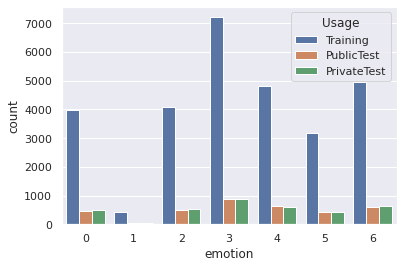

In [14]:
ax = sns.countplot(x="emotion", hue="Usage", data=data)

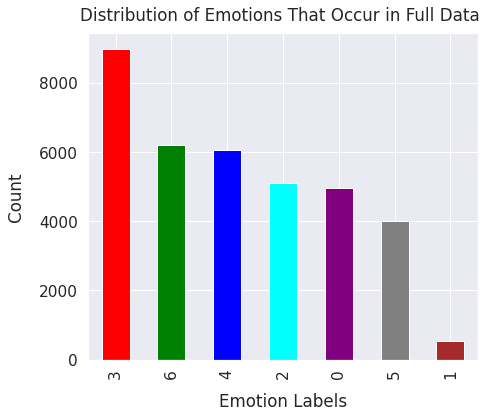

In [15]:
sns.set(font_scale=1.4)
data.emotion.value_counts().plot(kind='bar', figsize=(7, 6), color=['red', 'green', 'blue', 'cyan', "purple", "grey", "brown"])
plt.xlabel("Emotion Labels", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Distribution of Emotions That Occur in Full Data ", y=1.02);

### Analysis of Train Data:

#### Exploring the Data Set

Plotting the sub-folders of the train folder (which equal the classes for our classification)

In [16]:
train_directory: str = "train/"
train_dir = os.listdir(train_directory)
classes: List[str] = [folder for folder in train_dir]
classes

['Neutral', 'Angry', 'Surprise', 'Sad', 'Happy', 'Disgust', 'Fear']

Plotting the amount of training data (images) for each emotion (given above: Sad, Disgust, Angry, Happy, Neutral, Surprise, Fear)

In [17]:
def count_files(dir):
    return len([1 for x in list(os.scandir(dir)) if x.is_file()])

count_train: List[int] = [count_files(train_directory + folder + "/") for folder in train_dir]
count_train

[4965, 3995, 3171, 4830, 7215, 436, 4097]

In [18]:
data.emotion[data.Usage == "Training"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Text(0, 0.5, 'Counts')

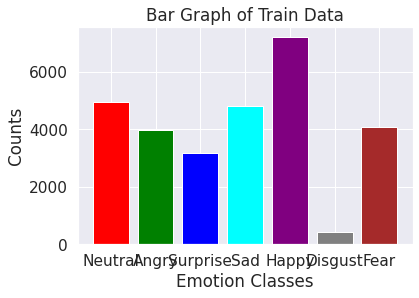

In [19]:
plt.bar(classes, count_train,color=['red', 'green', 'blue', 'cyan', "purple", "grey", "brown"])
plt.rcParams["figure.figsize"] = (12,6)
plt.title("Bar Graph of Train Data")
plt.xlabel("Emotion Classes")
plt.ylabel("Counts")

*   Displaying the amount of training data per emotion

*   It can be clearly said, that except for the Disgust emotion the dataset is fairily balanced


Scatter Plot as another approach on how to present the data:
*   Displaying the amount of training data per emotion

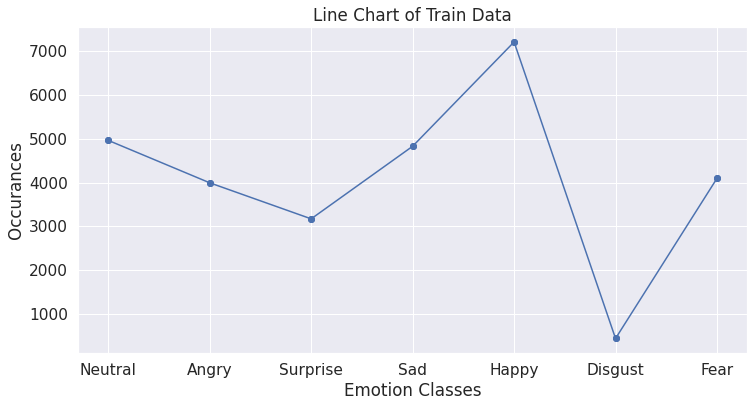

In [20]:
plt.scatter(classes, count_train) #color=['red', 'green', 'blue', 'cyan', "purple", "grey", "brown"])
plt.plot(classes, count_train, '-o')
plt.rcParams["figure.figsize"] = (12,6)
plt.title("Line Chart of Train Data")
plt.xlabel("Emotion Classes")
plt.ylabel("Occurances")
plt.show()

#### Reading and Analyzing the Images:

*   To take a closer look at the images we are working with, we pick a random image from a random folder
*   This image is to be taken for some showcasing and analysing

In [21]:
for folder in train_dir:
    emo_path = train_directory + folder + "/"
    for file in os.listdir(emo_path):
        if file.endswith(".jpg"):
            final_path = emo_path + file
            print(final_path)
            #load image as original (including alpha channel), other wise it would be b/w
            img = cv2.imread(final_path, -1)
        break
    break

train/Neutral/1046.jpg


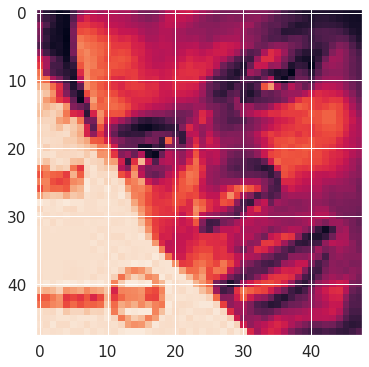

In [22]:
plt.imshow(img)

#### More Granular Exploration of the Images

In [23]:
height, width = img.shape

print("Height of image = " + str(height) + "\nWidth of the image = " + str(width))

Height of image = 48
Width of the image = 48


Next we are extracting one (random) image from each emotion folder for display


In [24]:
image_paths: List[str] = []

for folder in train_dir:
    emo_path = train_directory + folder + "/"
    for file in os.listdir(emo_path):
        if file.endswith(".jpg"):
            final_path = emo_path + file
            image_paths.append(final_path)
        break

In [25]:
#displaying image paths of example images
image_paths

['train/Neutral/1046.jpg',
 'train/Angry/1046.jpg',
 'train/Surprise/1046.jpg',
 'train/Sad/1046.jpg',
 'train/Happy/5627.jpg',
 'train/Disgust/98.jpg',
 'train/Fear/1046.jpg']

Displaying the example images using matplotlib.image

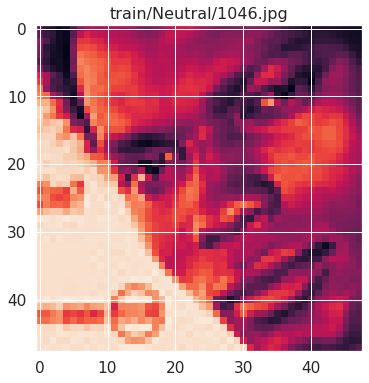

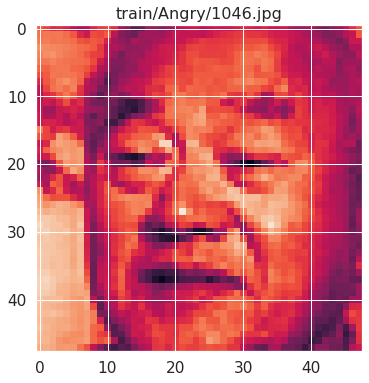

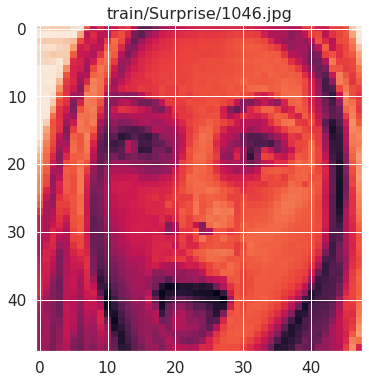

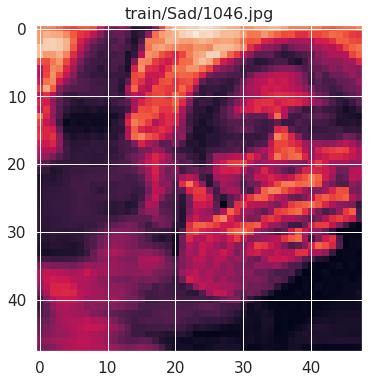

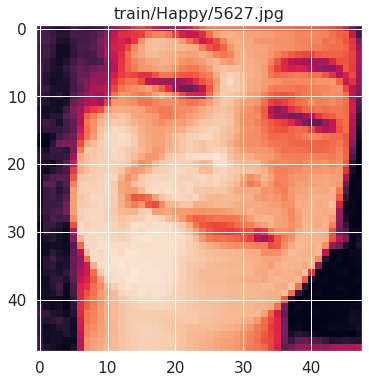

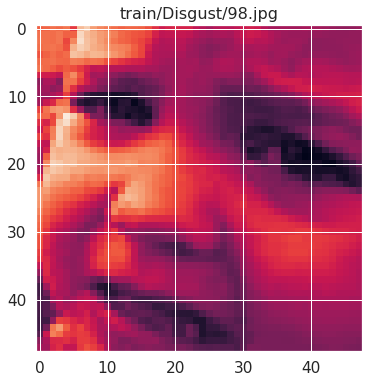

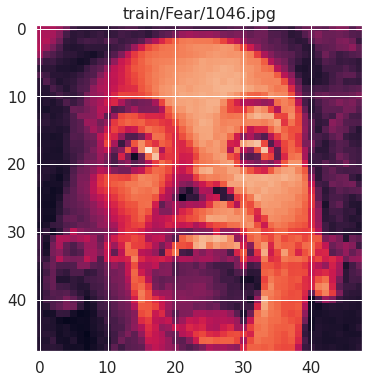

In [26]:
import matplotlib.image as mpimg

for file in image_paths:
    image = mpimg.imread(file)
    plt.figure()
    title = str(file)
    plt.title(title, fontsize = 16)
    plt.imshow(image)

### Analysis of Validation Data:

- We execute the same data exploration for the train data as we did for the test data (to ensure the quality of the validation set)

Displaying the sub-folders in the train folder (which equal the classes for our classification)

In [27]:
val_directory: str = "validation/"
val_dir = os.listdir(val_directory)
classes: List[str] = [folder for folder in val_dir]
classes

['Neutral', 'Angry', 'Surprise', 'Sad', 'Happy', 'Disgust', 'Fear']

Display the amount of training data (images) for each emotion (given above: Sad, Disgust, Angry, Happy, Neutral, Surprise, Fear)

In [28]:
count_val: List[int] = [count_files(val_directory + folder + "/") for folder in val_dir]
count_val

[1233, 958, 831, 1247, 1774, 111, 1024]

In [29]:
data.emotion[data.Usage != "Training"].value_counts()

3    1774
4    1247
6    1233
2    1024
0     958
5     831
1     111
Name: emotion, dtype: int64

Bar Graph:

Text(0, 0.5, 'Counts')

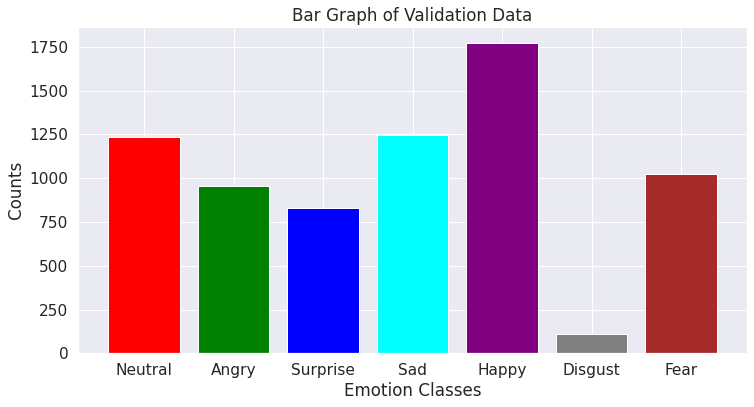

In [30]:
plt.bar(classes, count_val, color=['red', 'green', 'blue', 'cyan', "purple", "grey", "brown"])
plt.rcParams["figure.figsize"] = (12,6)
plt.title("Bar Graph of Validation Data")
plt.xlabel("Emotion Classes")
plt.ylabel("Counts")

Scatter Plot:

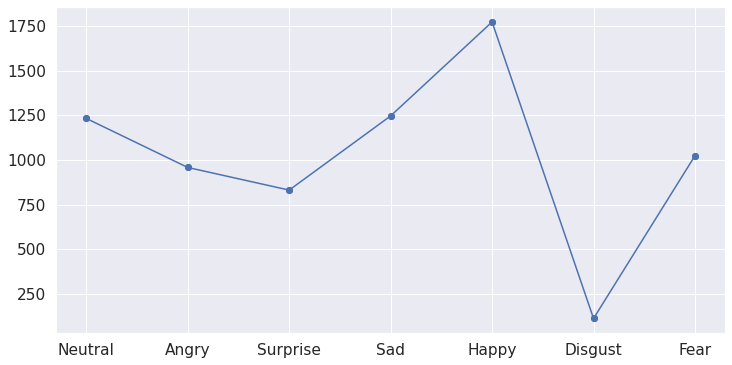

In [31]:
plt.scatter(classes, count_val)
plt.plot(classes, count_val, '-o')
plt.show()

#### Reading and Analyzing the Validation Images:

To take a closer look at the images we are working with we take a random image from a random folder. We will use this image for some further analysis.

In [32]:
for folder in val_dir:
    emo_path = val_directory + folder + "/"
    for file in os.listdir(emo_path):
        if file.endswith(".jpg"):
            final_path = emo_path + file
            print(final_path)
            #load image as original (including alpha channel), other wise it would be b/w
            img = cv2.imread(final_path, -1)
        break
    break

validation/Neutral/5627.jpg


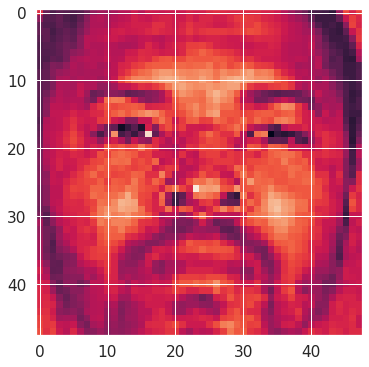

In [33]:
plt.imshow(img)

In [34]:
height, width= img.shape

print("Height of image = " + str(height) + "\nWidth of the image = " + str(width))

Height of image = 48
Width of the image = 48


Extracting one (random) image from each emotion folder for display


In [35]:
image_paths: List[str] = []

for folder in val_dir:
    emo_path = val_directory + folder + "/"
    for file in os.listdir(emo_path):
        if file.endswith(".jpg"):
            final_path = emo_path + file
            image_paths.append(final_path)
        break

In [36]:
#displaying paths of example images
image_paths

['validation/Neutral/5627.jpg',
 'validation/Angry/4196.jpg',
 'validation/Surprise/3987.jpg',
 'validation/Sad/5627.jpg',
 'validation/Happy/8738.jpg',
 'validation/Disgust/456.jpg',
 'validation/Fear/4196.jpg']

Displaying the example images using matplotlib

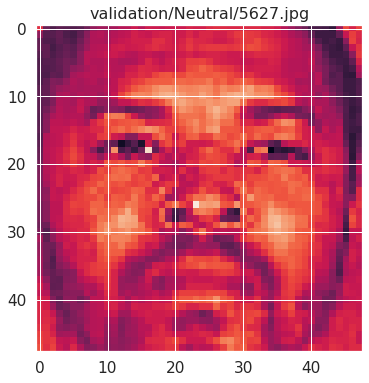

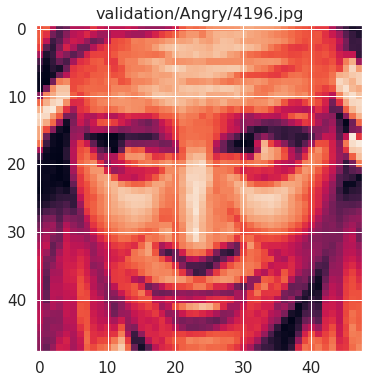

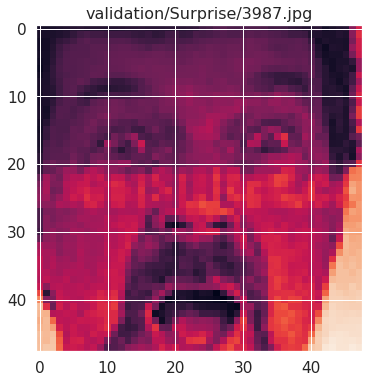

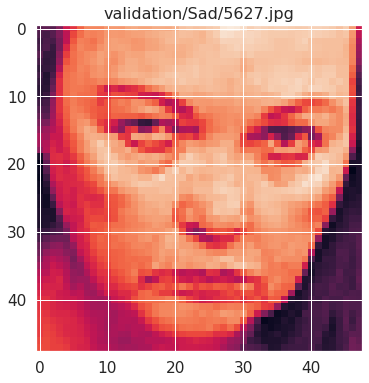

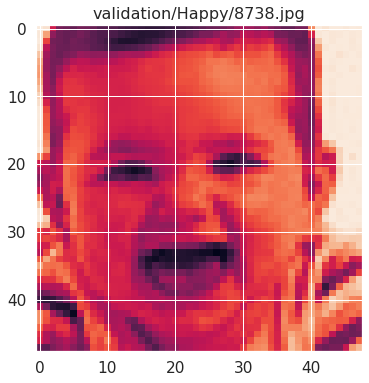

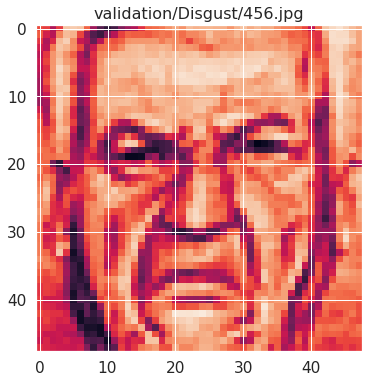

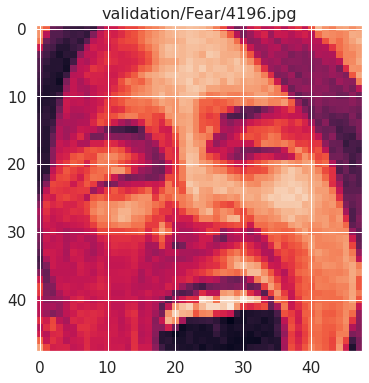

In [37]:
import matplotlib.image as mpimg

for file in image_paths:
    image = mpimg.imread(file)
    plt.figure()
    title = str(file)
    plt.title(title, fontsize = 16)
    plt.imshow(image)

#### Fazit on Images:
- We have a fairly balanced dataset (for training and validation)
- All images are of the format 48x48
- All images are grayscaled (one channel)

# Training the Emotion Detection Model (1st Attempt):

In this section we will be training the emotion detection model and we will try to achieve a good accuracy for          the model.

###Importing Deep Learning Libraries 
*   Keras is an API which can run on top of tensorflow library
*   Tensorflow is the main deep learning module that we are to use to build our Emotion Detection Model
*   ImageDataGenerator for Data Augmentation where the model can see more copies of the model -> used for creating replications of the original images and using them in each epoch
*   A Neural Network consists basically of layers:
1. Input Layer = Layer which we pass the input shape
2. Conv2D = 2D Convolution Layer (e.g. spatial convolution over images). This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs
3. Maxpool2D = Downsampling Data from Convolutional Layer
4. Batch Normalization = Is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling
5. Dropout = Technique where randomly selected neurons are ignored during training (basically they are dropped out to prevent over-fitting)
6. Fully Connected Layers
7. Flatten = Flatten/Convert the entire structure to 1D vector
8. regulization for fine tuning

*   Optimizer "Adam" due to its performance benefits compared to other optimizers for our model



In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import numpy as np
import pydot_ng
import graphviz
import os

###Initializing Variables

In [ ]:
num_classes: int = len(set(labels)) #defines the number of classes we have to predict (Angry, Fear, Sad, Happy, Neutral, Surprise and Neutral)
Img_Height: int = img.shape[0] #pixels of image
Img_Width: int =  img.shape[1] #pixels of image

batch_size: int = 32 #for the training of the image augmentation

In [ ]:
num_classes, Img_Height, Img_Width

(7, 48, 48)

In [ ]:
os.chdir("/gdrive/My Drive/Datasets/") #change dir to gdrive if the data is stored there (otherwise do not execute this line)

In [ ]:
train_dir: str = "train" #specify train dir for stored images
validation_dir: str = "validation" #specify val dir for stored images
os.getcwd()

'/gdrive/My Drive/Datasets'

### Data Augmentation of images:

Reference: https://keras.io/api/preprocessing/image/
*   As already mentioned, the ImageDataGen is used for data augmentation of images (it extends the data set by adding modified copies - this is necessary due to a lack of data for heavy deep learning techniques)
*   We are to rescale the images and update/fit all the parameters to suit our model
1. Rescale = Rescaling by 1/255 to normalize each single pixel value
2. rotation_range = random range of rotation
3. shear_range = intensity of each angle in counter-clockwise range
4. room_range = determine range of zooming
5. width_shift = width of extension
6. height_shift = height of extentsion
7. horizontal_flip = images are flipped horizontally
8. fill_mode = accoring to the closest boundaries

train_datagen.flow_from_directory
*   Takes path to a dir and generates batches of augmented data
1. train_dir = dir where data is stored
2. color_mode = How are the images categorized (RGB or greyscale)
3. target_size = dimensions of the image
4. batch_size = number of batches
5. class_mode = Determines the type of label arrays that are returned. For our purposes ("categorical" will be 2D one-hot encoded labels)
6. Shuffle = If false, data in alphabetical order

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    color_mode='grayscale',
                                                    target_size=(Img_Height, Img_Width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              color_mode='grayscale',
                                                              target_size=(Img_Height, Img_Width),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7050 images belonging to 7 classes.


### Emotions Model:

We are going to use a sequential type architecture for the model. It consists of a total of 5 blocks (3 convolutional blocks, 1 fully connected layer and finally 1 output layer)
*   Filter size of the first 3 layers (convolutional layers) are increasing (32, 64, 128) while number of rows and columns decreasing
*   Kernel_size (3,3) - kernal_initializer "he_normal"
*   Activation = "elu" due to it usually performs better on spatial (images) data
*   Input shape equals the size of each of our train and validation images
*   BatchNormalization is a technique for improving speed, performance and stability of NN
*   Max2D / Maxpooling for downsampling of the data
*   Dropout Layer to reduce overfitting 
*   4 Block (Fully Connected Layer) consists of 1. 64 Filters, 2. BatchNorm, 3. Dropout Layer
*   Before passing through Dense Layer the data is flattened in order to match the dimensions
*  5 Block (Output Layer) consists of Dense Layer with softmax activation (gives probabilites according to the amount of classes (7) which means the number of predictions that are to be made

In [ ]:
model = Sequential()

#Block1: The First Convolutional Block

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", 
                 input_shape=(Img_Height, Img_Width, 1), 
                 name="Conv1"))

model.add(BatchNormalization(name="Batch_Norm1"))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv2"))

model.add(BatchNormalization(name="Batch_Norm2"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool1"))
model.add(Dropout(0.2, name="Dropout1"))

#Block2: The Second Convolutional Block

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", name="Conv3"))

model.add(BatchNormalization(name="Batch_Norm3"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv4"))

model.add(BatchNormalization(name="Batch_Norm4"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool2"))
model.add(Dropout(0.2, name="Dropout2"))

#Block3: The Third Convolutional Block

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="elu", name="Conv5"))

model.add(BatchNormalization(name="Batch_Norm5"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="elu", name="Conv6"))

model.add(BatchNormalization(name="Batch_Norm6"))
model.add(MaxPooling2D(pool_size=(2,2), name="Maxpool3"))
model.add(Dropout(0.2, name="Dropout3"))

#4 Block: The Fully Connected Block

model.add(Flatten(name="Flatten"))
model.add(Dense(64, activation="elu", kernel_initializer='he_normal', name="Dense"))
model.add(BatchNormalization(name="Batch_Norm7"))
model.add(Dropout(0.5, name="Dropout4"))

#5 Block: The Output Block

model.add(Dense(num_classes, activation="softmax", kernel_initializer='he_normal', name = "Output"))

### Model Overview: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 48, 48, 32)        320       
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 Conv2 (Conv2D)              (None, 48, 48, 32)        9248      
                                                                 
 Batch_Norm2 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 Maxpool1 (MaxPooling2D)     (None, 24, 24, 32)        0         
                                                                 
 Dropout1 (Dropout)          (None, 24, 24, 32)        0

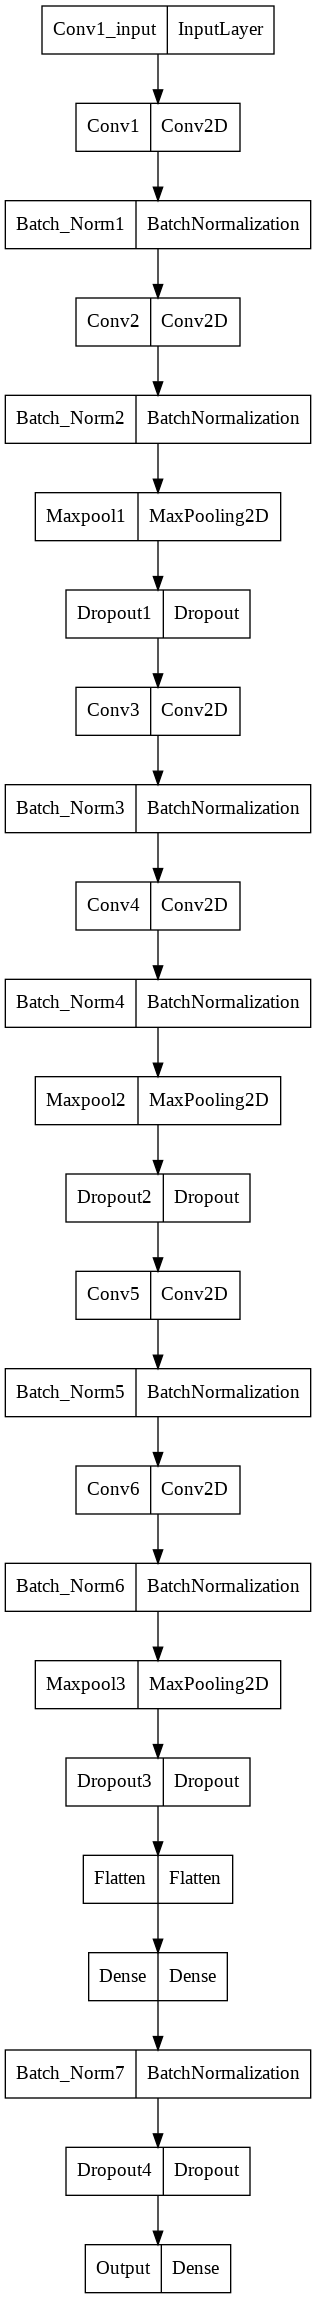

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model, to_file='DeepLearningModel.png', show_layer_names=True)

### Callbacks:
*  We change dir to "/content/" to provide a faster learning process (due to not accessing to google drive each time (logs and saving model each epoch rate))

In [ ]:
os.chdir('/content/')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("emotions.h5", monitor='accuracy', verbose=1,
                              save_best_only=True, mode='auto', save_freq=1)
#Reduce learning rate when the accurady has stopped improving
reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=10, 
                           min_lr=0.0001, verbose = 1)

logdir='logs'
tensorboard_Visualization = TensorBoard(log_dir=logdir, histogram_freq=False)

### Compile the Model:

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics=['accuracy'])

In [ ]:
data[data["Usage"] == "Training"].shape #checking amount of train samples

(28709, 3)

In [ ]:
sum(count_train) #compare with stored data 

28709

In [ ]:
sum(count_val)/2 #compute amount of val data for next step

3589.0

In [ ]:
data[data["Usage"] == "PublicTest"].shape #compare with original data (the one that got loaded into a DataFrame)

(3589, 3)

## Fit the Model:

In [ ]:
train_samples: int = sum(count_train)
validation_samples: int = int(sum(count_val)/2)
epochs: int = 150
batch_size: int = 64

model.fit(train_generator,
          steps_per_epoch = train_samples//batch_size,
          epochs = epochs,
          callbacks = [checkpoint, reduce, tensorboard_Visualization],
          validation_data = validation_generator,
          validation_steps = validation_samples//batch_size,
          shuffle=True)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
195/448 [============>.................] - ETA: 12s - loss: 1.3487 - accuracy: 0.4859
Epoch 145: accuracy did not improve from 0.71875

Epoch 145: accuracy did not improve from 0.71875
197/448 [============>.................] - ETA: 12s - loss: 1.3471 - accuracy: 0.4860
Epoch 145: accuracy did not improve from 0.71875

Epoch 145: accuracy did not improve from 0.71875
199/448 [============>.................] - ETA: 11s - loss: 1.3462 - accuracy: 0.4863
Epoch 145: accuracy did not improve from 0.71875

Epoch 145: accuracy did not improve from 0.71875
201/448 [============>.................] - ETA: 11s - loss: 1.3456 - accuracy: 0.4863
Epoch 145: accuracy did not improve from 0.71875
202/448 [============>.................] - ETA: 11s - loss: 1.3465 - accuracy: 0.4862
Epoch 145: accuracy did not improve from 0.71875
203/448 [============>.................] - ETA: 11s - loss: 1.3459 - accuracy: 0.4871
Epoch 145: accuracy di

## Graph:

Analysing the training results in Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="./logs"

## Summary:
The Model is able to perform well. We can notice that the train and validation losses are decreasing constantly and the train as well as validation accuracys increase constantly. There is no overfitting in the deep learning model and we are able to achieve an validation accuracy of about 53%.

# Training the Final Emotion Detection Model (2nd Attempt - Better Accuracy)

## Importing Deep Learning Libraries 2.0

In [38]:
#same libraries as for the first model

import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pydot_ng
import graphviz
import os
from typing import List

In [39]:
num_classes: int = len(set(labels))
batch_size: int = 64
epochs: int = 100
Img_height: int = img.shape[0]
Img_width: int = img.shape[1]

In [40]:
# Have a quick look on the data again
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


We transform the data contained in our first dataframe (data) to "faces" and "emotions" those are later used to create the train and test data for this model:
* faces is a 4D array:
  * the outer array contains the images (35887)
  * the next two inner arrays represent the pixels (48x48)
  * each pixel value is in another aray

* emotions is a 2D array:
  * the columns represent the 7 emotions 
  * each row represents an image
  * the values are 0 or 1 indicating which emotion is displayed in the corresponding image (six times 0, one 1 per row)

In [41]:
pixels: List[str] = [pixel for pixel in data.pixels] # Convert pixels to list
faces: List = []

for pixel_seq in pixels:
    face = [int(pixel) for pixel in pixel_seq.split(' ')] # Splitting by spaces
    face = np.asarray(face).reshape(Img_height, Img_width)  #convert to arrays and reshaping
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1) #expand dimensions


emotions = pd.get_dummies(data['emotion']).values

In [42]:
faces.shape

(35887, 48, 48, 1)

In [43]:
# categorical matrix of converted labels
emotions

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

## Splitting of data:

In [44]:
# Using train_test_split from sklearn for dividing data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

## Emotions Model:
We are going to use a sequential type architecture for the model. It consists of a total of 5 blocks (3 convolutional blocks, 1 fully connected layer and finally 1 output layer)
*   Filter size of the first 3 layers (convolutional layers) are increasing (32, 64, 128) while number of rows and columns decreasing
*   Kernel_size (3,3) - kernal_initializer "he_normal"
*   Activation = "elu" due to it usually performing better on spatial (images) data
*   Input shape equals the size of each of our train and validation images
*   BatchNormalization is a technique for improving speed, performance and stability of NN
*   Max2D / Maxpooling for downsampling the data
*   Dropout Layer to reduce overfitting 
*   4 Block (Fully Connected Layer) consists of 1. 64 Filters, 2. BatchNorm, 3. Dropout Layer
*   Before passing through Dense Layer the data is flattend in order to match the dimensions
*  5 Block (Output Layer) consists of Dense Layer with softmax activation (gives probabilites according to the amount of classes (7) which means the number of predictions that are to be made

In [45]:
model_final = Sequential()

# First Convolutional Block

model_final.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", 
                 input_shape=(Img_height, Img_width, 1), 
                 name="Conv1"))

model_final.add(BatchNormalization(name="Batch_Norm1"))

model_final.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv2"))

model_final.add(BatchNormalization(name="Batch_Norm2"))
model_final.add(MaxPooling2D(pool_size=(2,2), name="Maxpool1"))
model_final.add(Dropout(0.5, name="Dropout1"))

# Second Convolutional Block

model_final.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", name="Conv3"))

model_final.add(BatchNormalization(name="Batch_Norm3"))

model_final.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv4"))

model_final.add(BatchNormalization(name="Batch_Norm4"))
model_final.add(MaxPooling2D(pool_size=(2,2), name="Maxpool2"))
model_final.add(Dropout(0.5, name="Dropout2"))

# Third Convolutional Block

model_final.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal', 
                 activation="relu", name="Conv5"))

model_final.add(BatchNormalization(name="Batch_Norm5"))

model_final.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', 
                 kernel_initializer='he_normal',
                 activation="relu", name="Conv6"))

model_final.add(BatchNormalization(name="Batch_Norm6"))
model_final.add(MaxPooling2D(pool_size=(2,2), name="Maxpool3"))
model_final.add(Dropout(0.5, name="Dropout3"))

# Fully Connected Block

model_final.add(Flatten(name="Flatten"))
model_final.add(Dense(64, activation="relu", kernel_initializer='he_normal', name="Dense"))
model_final.add(BatchNormalization(name="Batch_Norm7"))
model_final.add(Dropout(0.5, name="Dropout4"))

# Output Block

model_final.add(Dense(num_classes, activation="softmax", kernel_initializer='he_normal', name = "Output"))

## Model Overview: 

In [46]:
model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 48, 48, 32)        320       
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 Conv2 (Conv2D)              (None, 48, 48, 32)        9248      
                                                                 
 Batch_Norm2 (BatchNormaliza  (None, 48, 48, 32)       128       
 tion)                                                           
                                                                 
 Maxpool1 (MaxPooling2D)     (None, 24, 24, 32)        0         
                                                                 
 Dropout1 (Dropout)          (None, 24, 24, 32)        0

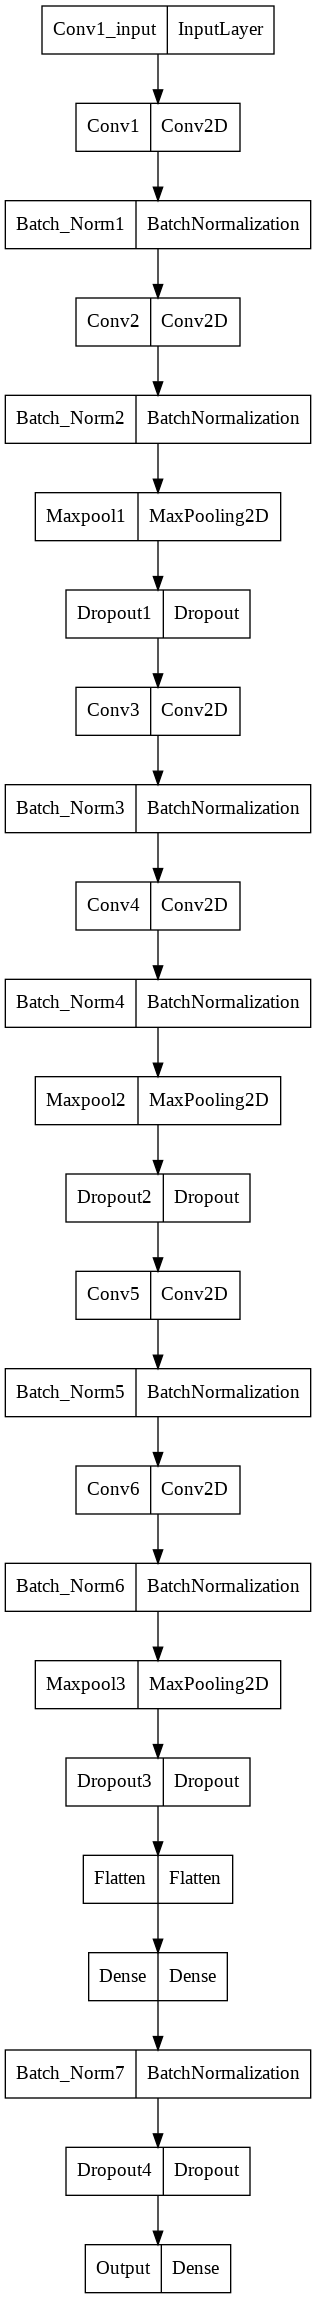

In [47]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils

keras.utils.plot_model(model_final, to_file='DeepLearningModelFinal.png', show_layer_names=True)

## Compile the Model:

In [48]:
model_final.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

## Callbacks:

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

tensorboard = TensorBoard(log_dir='logs_final')
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("emotions_final.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

## Fit the Model:

In [ ]:
history = model_final.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 2.0624 - accuracy: 0.2549
Epoch 1: val_accuracy improved from -inf to 0.36250, saving model to emotions_final.h5
455/455 [==============================] - 22s 19ms/step - loss: 2.0624 - accuracy: 0.2549 - val_loss: 1.6460 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 2/100
453/455 [============================>.] - ETA: 0s - loss: 1.6356 - accuracy: 0.3767
Epoch 2: val_accuracy improved from 0.36250 to 0.43243, saving model to emotions_final.h5
455/455 [==============================] - 8s 18ms/step - loss: 1.6350 - accuracy: 0.3770 - val_loss: 1.4777 - val_accuracy: 0.4324 - lr: 0.0010
Epoch 3/100
454/455 [============================>.] - ETA: 0s - loss: 1.4742 - accuracy: 0.4325
Epoch 3: val_accuracy improved from 0.43243 to 0.48203, saving model to emotions_final.h5
455/455 [==============================] - 8s 17ms/step - loss: 1.4741 - accuracy: 0.4326 - val_loss: 1.3633 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 

## Graph:

Analysing the training results in Tensorboard:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="./logs_final"

Using Matplotlib to plot the training and test accuracies for our model 

In [ ]:
history.history["accuracy"]

In [ ]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label ="val_accuracy")
plt.legend(["train", "test"], loc ="lower left")

The Model is able to perform quite well. We can notice that the train and validation losses are decreasing constantly and the train as well as validation accuracy increases constantly. There is no overfitting in the deep learning model and we are able to achieve an validation accuracy of over 65% and an accuracy of almost 72% and reduce the loss as well.

#Demonstration

## Prediction of normal foreign images (uploaded as .jpg)

In [ ]:
#download face recognition model (more info on this below)
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

* The following two functions both take the path of an image as an argument and return the classified emotion as a String. 
* emotion_detection_full_pic (the first function) also plots an the full image with a red rectangle around the detected face
* emotion_detection_zoom (the second function) also plots the face in grayscale (basically this is what our model gets as an input to preditct the emotion)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np 
import cv2
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



def emotion_detection_full_pic(img_path):
  #load test image:
  frame = cv2.imread(img_path)

  #load the previously trained and saved model
  emotion_model = load_model("emotions_final.h5")

  #load face classifier to aid the detection, if file does not exist, download it
  face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

  #save the emotion labels in correct order
  emotion_label = ['Angry', "Distgust", 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

  #catch error caused incorrectly passing the image or non-existance of the give file
  try:
    #transform image to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  except Exception:
    print("picture not passed correctly")
    return
  #face detection using downloaded model (this is a good modern model we did not create ourselfes)
  faces = face_classifier.detectMultiScale(gray,1.3,5)
  #terminating the function if no face was detected
  if str(type(faces)) == "<class 'tuple'>":
    return "no face found"

  for (x,y,w,h) in faces:
      #draw rectangle around detected face
      cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
      #cut out the detected face
      roi_gray = gray[y:y+h,x:x+w]
      #resize image to 48x48 since this is the required input size
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

      #reformatting image to correct forat to be passed to the model
      roi = img_to_array(roi_gray)
      roi = np.expand_dims(roi,axis=0)

      #predict emotion and get the emotion as a string
      preds = emotion_model.predict(roi)
      label = emotion_label[np.argmax(preds[0])]

      #plot image
      plt.title(img_path + label)
      plt.imshow(frame)
      return(label)
      cv2.destroyAllWindows()

In [ ]:
emotion_detection_full_pic("3.jpg")

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np 
import cv2
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



def emotion_detection_zoom(img_path):
  #load test image:
  frame = cv2.imread(img_path)

  #load the previously trained and saved model
  emotion_model = load_model("emotions_final.h5")

  #load face classifier to aid the detection, if file does not exist, download it
  face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

  #save the emotion labels in correct order
  emotion_label = ['Angry', "Distgust", 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


  try:
    #catching exception caused by the image incorrectly or passing passing no image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  except Exception:
    return "picture not passed correctly"

  #face detection using downloaded model (this is a good modern model we did not create ourselfes)
  faces = face_classifier.detectMultiScale(gray,1.3,5)

  #terminating the function if no face was detected
  if str(type(faces)) == "<class 'tuple'>":
    return "no face found"

  for (x,y,w,h) in faces:
      #draw rectangle around detected face
      cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
      #cut out the detected face
      roi_gray = gray[y:y+h,x:x+w]
      #resize image to 48x48 since this is the required input size
      roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
      #plot image
      plt.imshow(roi_gray)

      #reformatting image to correct forat to be passed to the model
      roi = img_to_array(roi_gray)
      roi = np.expand_dims(roi,axis=0)

      #predict emotion and get the emotion as a string
      preds = emotion_model.predict(roi)
      label = emotion_label[np.argmax(preds[0])]
      return label

In [ ]:
emotion_detection_zoom("8.jpg")

## Predicting the emotion of a train or test image

The next three cells contain a very basic prediction of one of our train or test images (it works with both).
This is intended only for exloratory purposes.
To be executed the training process has to be executed beforehand since this code relies on the model to already be in-memory (in contrast to the above functions which load a saved model from a file)

In [ ]:
num_labels = list(set(labels))
cat_labels: List[str] = ['Angry', "Distgust", 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
label_dic = {k: v for k, v in zip(num_labels, cat_labels)}
#displaying which number represents which emotion
label_dic

In [ ]:
#predicting the train set and getting the prediction for one of those images (image number x)
x=100
output = model_final.predict(X_train)
prediction = np.argmax(output[x])
prediction

In [ ]:
#plotting the image to evaluate the models performance
image=X_train[x].reshape(48,48)
plt.imshow(image)
plt.show()